C:\Users\Administrator\AppData\Local\Temp\ipykernel_9916\303371792.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


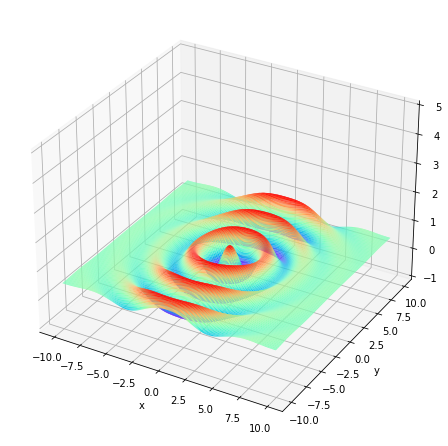

In [1]:
# 画出图像如下
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)
X, Y = np.meshgrid(x, y)       
Z = 0.5 - (np.sin(np.sqrt(X**2+Y**2))**2 - 0.5)/(1 + 0.001*(x**2 + y**2)**2)
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlim([-1,5])
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')
plt.show()

In [2]:
import math, random

class Population:
    # 种群的设计
    def __init__(self, size, chrom_size, cp, mp, gen_max):
        # 种群信息合
        self.individuals = []          # 个体集合
        self.fitness = []              # 个体适应度集
        self.selector_probability = [] # 个体选择概率集合
        self.new_individuals = []      # 新一代个体集合

        self.elitist = {'chromosome':[0, 0], 'fitness':0, 'age':0} # 最佳个体的信息

        self.size = size # 种群所包含的个体数
        self.chromosome_size = chrom_size # 个体的染色体长度
        self.crossover_probability = cp   # 个体之间的交叉概率
        self.mutation_probability = mp    # 个体之间的变异概率
         
        self.generation_max = gen_max # 种群进化的最大世代数
        self.age = 0                  # 种群当前所处世代
          
        # 随机产生初始个体集，并将新一代个体、适应度、选择概率等集合以 0 值进行初始化
        v = 2 ** self.chromosome_size - 1
        for i in range(self.size):
            self.individuals.append([random.randint(0, v), random.randint(0, v)])
            self.new_individuals.append([0, 0])
            self.fitness.append(0)
            self.selector_probability.append(0)

    # 基于轮盘赌博机的选择

    # interval 为x,y取值的范围
    # 将染色体映射会 变量的取值范围
    def decode(self, interval, chromosome):
        '''将一个染色体 chromosome 映射为区间 interval 之内的数值'''
        d = interval[1] - interval[0]
        n = float (2 ** self.chromosome_size -1)
        return (interval[0] + chromosome * d / n)
     
    def fitness_func(self, chrom1, chrom2):
        '''适应度函数，可以根据个体的两个染色体计算出该个体的适应度'''
        # interval为变量x,y的取值范围
        interval = [-10.0, 10.0]
        # 将染色体复原为该取得值
        (x, y) = (self.decode(interval, chrom1), 
                  self.decode(interval, chrom2))
        
        # 下面为适应度函数 把x,y代入要求解的函数
        n = lambda x, y: math.sin(math.sqrt(x*x + y*y)) ** 2 - 0.5
        d = lambda x, y: (1 + 0.001 * (x*x + y*y)) ** 2
        func = lambda x, y: 0.5 - n(x, y)/d(x, y)


        return func(x, y)
         
    def evaluate(self):
        '''用于评估种群中的个体集合 self.individuals 中各个个体的适应度'''
        # 初始化挑选的概率
        sp = self.selector_probability
        # 遍历种群包含的个体数
        for i in range (self.size):
            # 个体适应度集合
            # 遍历个体集合 把个体集合(每一条染色体)经过适应度函数计算得到的结果存到个体适应度集合
            # individuals[i][0]为x individuals[i][1]为y
            self.fitness[i] = self.fitness_func (self.individuals[i][0],   # 将计算结果保存在 self.fitness 列表中
                                                 self.individuals[i][1])
            
        # 计算所有个体适应度集合的总和
        # 通过总和计算每一个个体的百分比
        ft_sum = sum (self.fitness)
        for i in range (self.size):
            # 通过每一条染色体占的百分比来确定染色体生存的概率
            sp[i] = self.fitness[i] / float (ft_sum)   # 得到各个个体的生存概率
        for i in range (1, self.size):
            # 需要将个体的生存概率进行叠加，从而计算出各个个体的选择概率
            sp[i] = sp[i] + sp[i-1]   

    # 轮盘赌博机（选择）
    def select(self):
        (t, i) = (random.random(), 0)
        for p in self.selector_probability:
            if p > t:
                break
            i = i + 1
        return i

    # 交叉
    def cross(self, chrom1, chrom2):
        p = random.random()    # 随机概率
        n = 2 ** self.chromosome_size -1
        if chrom1 != chrom2 and p < self.crossover_probability:
            t = random.randint(1, self.chromosome_size - 1)   # 随机选择一点（单点交叉）
            mask = n << t    # << 左移运算符
            (r1, r2) = (chrom1 & mask, chrom2 & mask)   # & 按位与运算符：参与运算的两个值,如果两个相应位都为1,则该位的结果为1,否则为0
            mask = n >> (self.chromosome_size - t)
            (l1, l2) = (chrom1 & mask, chrom2 & mask)
            (chrom1, chrom2) = (r1 + l2, r2 + l1)
        return (chrom1, chrom2)

    # 变异
    def mutate(self, chrom):
        p = random.random ()
        if p < self.mutation_probability:
            t = random.randint (1, self.chromosome_size)
            mask1 = 1 << (t - 1)
            mask2 = chrom & mask1
            if mask2 > 0:
                chrom = chrom & (~mask2)  # ~ 按位取反运算符：对数据的每个二进制位取反,即把1变为0,把0变为1 
            else:
                chrom = chrom ^ mask1   # ^ 按位异或运算符：当两对应的二进位相异时，结果为1 
        return chrom

    # 保留最佳个体
    def reproduct_elitist (self):
        # 与当前种群进行适应度比较，更新最佳个体
        j = -1
        for i in range (self.size):
            if self.elitist['fitness'] < self.fitness[i]:
                j = i
                self.elitist['fitness'] = self.fitness[i]
        if (j >= 0):
            self.elitist['chromosome'][0] = self.individuals[j][0]
            self.elitist['chromosome'][1] = self.individuals[j][1]
            self.elitist['age'] = self.age

    # 进化过程
    def evolve(self):
        indvs = self.individuals
        new_indvs = self.new_individuals
        # 计算适应度及选择概率
        self.evaluate()
        # 进化操作
        i = 0
        while True:
            # 选择两个个体，进行交叉与变异，产生新的种群
            idv1 = self.select()
            idv2 = self.select()
            # 交叉
            # 根据轮盘的概率 选择哪两条染色体来变异
            (idv1_x, idv1_y) = (indvs[idv1][0], indvs[idv1][1]) # 染色体1
            (idv2_x, idv2_y) = (indvs[idv2][0], indvs[idv2][1]) # 染色体2
            #染色体交叉
            (idv1_x, idv2_x) = self.cross(idv1_x, idv2_x)
            (idv1_y, idv2_y) = self.cross(idv1_y, idv2_y)
            # 变异
            (idv1_x, idv1_y) = (self.mutate(idv1_x), self.mutate(idv1_y))
            (idv2_x, idv2_y) = (self.mutate(idv2_x), self.mutate(idv2_y))
            (new_indvs[i][0], new_indvs[i][1]) = (idv1_x, idv1_y)  # 将计算结果保存于新的个体集合self.new_individuals中
            (new_indvs[i+1][0], new_indvs[i+1][1]) = (idv2_x, idv2_y)
            # 判断进化过程是否结束
            i = i + 2         # 循环self.size/2次，每次从self.individuals 中选出2个
            if i >= self.size:
                break
        
        # 最佳个体保留
        # 如果在选择之前保留当前最佳个体，最终能收敛到全局最优解。
        self.reproduct_elitist()

        # 更新换代：用种群进化生成的新个体集合 self.new_individuals 替换当前个体集合
        for i in range (self.size):
            self.individuals[i][0] = self.new_individuals[i][0]
            self.individuals[i][1] = self.new_individuals[i][1]

    def run(self):
        '''根据种群最大进化世代数设定了一个循环。
        在循环过程中，调用 evolve 函数进行种群进化计算，并输出种群的每一代的个体适应度最大值、平均值和最小值。'''
        for i in range (self.generation_max):
            self.evolve ()
            print (i, max (self.fitness), sum (self.fitness)/self.size, min (self.fitness))
if __name__ == '__main__':
    # 种群的个体数量为 50，染色体长度为 25，交叉概率为 0.8，变异概率为 0.1,进化最大世代数为 150
    # pop = Population (50, 24, 0.8, 0.1, 150)
    pop = Population (50, 24, 0.8, 0.1, 300)
    pop.run()

0 0.962501593719129 0.4839898349324532 0.038300983539622746
1 0.9621422331956098 0.7081089195334286 0.06797195974529552
2 0.959762814329411 0.709980190039145 0.09330354925652501
3 0.9708808691954117 0.7431606399206452 0.02152416906745147
4 0.9803856333442174 0.7886456100706848 0.04811541026561916
5 0.9641653691711681 0.8261891815021769 0.1754837629561602
6 0.9641972595924158 0.7797405447589167 0.0024582329668010328
7 0.9900441146454455 0.7496301710337907 0.056735594629016894
8 0.980405885016121 0.7244548564773834 0.04202079838013617
9 0.9612164634021818 0.7705552581930764 0.022227393899136638
10 0.9617397804681858 0.7865284860867683 0.02169712470672125
11 0.9620679181551746 0.7962312020553522 0.2615257638694379
12 0.9620679181551746 0.7981085408241921 0.3480653640450295
13 0.9625719148387673 0.794268788961983 0.040384044975096955
14 0.9626052411350532 0.809559766445856 0.1900389030903385
15 0.9620998498286326 0.7448822071377594 0.1615220503709826
16 0.961977051292938 0.7969723057939754

In [3]:
import random

# 遗传算法的参数
population_size = 100  # 种群大小
mutation_rate = 0.1   # 变异率
num_generations = 50  # 迭代次数

# 适应度函数，即要最小化的函数
# 找到该函数的最小值
def fitness_function(x):
    return x**2

# 初始化种群
# 初始化了一个包含随机个体的种群，每个个体都是一个在[-10, 10]范围内随机生成的浮点数
def initialize_population():
    population = []
    for _ in range(population_size):
        individual = random.uniform(-10, 10)  # 随机生成个体
        population.append(individual)
    return population

# 选择
# 函数随机选择两个父代个体，这是遗传算法中的选择操作
def selection(population):
    # 选择两个随机个体
    parent1 = random.choice(population)
    parent2 = random.choice(population)
    return parent1, parent2

# 交叉
# 函数执行一点交叉操作，将两个父代个体通过加权平均的方式组合为两个子代个体
def crossover(parent1, parent2):
    # 一点交叉
    alpha = random.uniform(0, 1)
    child1 = alpha * parent1 + (1 - alpha) * parent2
    child2 = alpha * parent2 + (1 - alpha) * parent1
    return child1, child2

# 变异
# 函数对子代进行变异，以一定的概率在子代个体上添加一个小的随机变化
def mutation(child):
    if random.random() < mutation_rate:
        mutation_amount = random.uniform(-0.5, 0.5)
        child += mutation_amount
    return child

# 主要的遗传算法循环
population = initialize_population()
for generation in range(num_generations): #遍历迭代次数
    new_population = []
    for _ in range(population_size // 2):
        parent1, parent2 = selection(population)
        child1, child2 = crossover(parent1, parent2)
        child1 = mutation(child1)
        child2 = mutation(child2)
        new_population.extend([child1, child2])
    population = new_population

# 找到最优解
best_solution = max(population, key=fitness_function)
best_fitness = fitness_function(best_solution)

print(f"最优解: {best_solution}")
print(f"最优解的适应度值: {best_fitness}")

最优解: -3.1615348256914184
最优解的适应度值: 9.995302454059667


In [4]:
# 求解非线性规划 二次规划模型

from scipy.optimize import minimize  #求解最优解
import numpy as np

xishu = np.array([4+3+3.5+0.3,0.0007,0.0004])
# 目标函数 min F = Fg1 + Fg2 + Fg3
def fun(x):
    global xishu
    #return (4+3+3.5+0.3*x[0] + 0.0007*x[0]**2+0.32*x[1] + 0.0004*x[1]**2 + 0.3*x[2]+0.00045*x[2]**2)
    c = 0
    for i in range(3):
        c = c + x[i] * xishu[i]
    return c
# 约束条件
def cons(x):
    # 约束条件分别为 eq（结果等于0）和ineq（表达式大于等于0）
    cons = ({'type':'eq','fun':lambda x : x[0] + x[1] + x[2] - 700})
    # 若是不等式约束 ineq（表达式大于等于0）
    #cons = ({'type':'ineq','fun':lambda x :-x[2]+x2max})
    #若是多个约束 cons = ([con1,con2]) 其中x[0]是具体数字
    return cons

b1,b2,b3 = (100,200),(120,250),(150,300)
bnds = (b1,b2,b3)

#设置x0猜测值
x0 = np.array((100,200,400))

res = minimize(fun,x0,method='SLSQP',constraints=cons(x0),bounds=bnds)
print(res)




     fun: 1620.2950000001133
     jac: array([1.07999878e+01, 7.01904297e-04, 3.96728516e-04])
 message: 'Optimization terminated successfully'
    nfev: 8
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([150., 250., 300.])


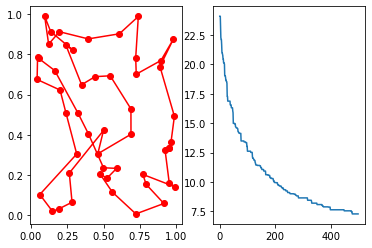

In [1]:
# sko库 图

import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt

num_points = 50
# 每个点的坐标系
points_coordinate = np.random.rand(num_points, 2)  # generate coordinate of points
# 每两个点的距离 shape(50, 50)
distance_matrix = spatial.distance.cdist(points_coordinate, points_coordinate, metric='euclidean')
# print(points_coordinate)
# print(distance_matrix.shape )
def cal_total_distance(routine):
    '''The objective function. input routine, return total distance.
    cal_total_distance(np.arange(num_points))
    '''
    num_points, = routine.shape
    return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])


from sko.GA import GA_TSP
# size_pop：这是种群的大小 prob_mut：这是变异操作的概率 1%
ga_tsp = GA_TSP(func=cal_total_distance, n_dim=num_points, size_pop=50, max_iter=500, prob_mut=1)
best_points, best_distance = ga_tsp.run()

fig, ax = plt.subplots(1, 2)
best_points_ = np.concatenate([best_points, [best_points[0]]])
best_points_coordinate = points_coordinate[best_points_, :]
ax[0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], 'o-r')
ax[1].plot(ga_tsp.generation_best_Y)
plt.show()




In [2]:
import numpy as np
from sko.GA import GA, GA_TSP
from sko.operators import ranking, selection, crossover, mutation

def selection_tournament(algorithm, tourn_size):
    FitV = algorithm.FitV
    sel_index = []
    for i in range(algorithm.size_pop):
        aspirants_index = np.random.choice(range(algorithm.size_pop), size=tourn_size)
        sel_index.append(max(aspirants_index, key=lambda i: FitV[i]))
    algorithm.Chrom = algorithm.Chrom[sel_index, :]  # next generation
    return algorithm.Chrom


demo_func = lambda x: x[0] ** 2 + (x[1] - 0.05) ** 2 + (x[2] - 0.5) ** 2
ga = GA(func=demo_func, n_dim=3, size_pop=100, max_iter=500, prob_mut=0.001,
        lb=[-1, -10, -5], ub=[2, 10, 2], precision=[1e-7, 1e-7, 1])

# %% step3: register your own operator
ga.register(operator_name='selection', operator=selection_tournament, tourn_size=3)
# %% Or import the operators scikit-opt already defined.

ga.register(operator_name='ranking', operator=ranking.ranking). \
    register(operator_name='crossover', operator=crossover.crossover_2point). \
    register(operator_name='mutation', operator=mutation.mutation)
# %% Run ga
best_x, best_y = ga.run()
print('best_x:', best_x, '\n', 'best_y:', best_y)

best_x: [-2.98023233e-08  4.99999898e-02  0.00000000e+00] 
 best_y: [0.25]
